# Bayesian Optimization

Adapted from Christian Forssen, TALENT Course 11, June, 2019, with extra documentation by Dick Furnstahl in November, 2019.

Selected references
* Paper: [Bayesian optimization in ab initio nuclear physics](https://iopscience.iop.org/article/10.1088/1361-6471/ab2b14) by A. Ekström, C. Forssén et al.,  J. Phys. G: Nucl. Part. Phys. 46, 095101 (2019).
* Book: Jonas Mockus (2012). Bayesian approach to global optimization: theory and applications. Kluwer Academic.
* Software: E.g., [GPyOpt](https://sheffieldml.github.io/GPyOpt/) from Sheffield ML. 
$  \newcommand{\thetavec}{\boldsymbol{\theta}} $

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")

import GPy
import GPyOpt   # This will do the Bayesian optimization

## Optimization of expensive objective functions

Let us first state an inconvenient fact about optimization:

> Global minimization is almost always intractable. In practice, we have to resort to local minimization:

$  \newcommand{\thetavec}{\boldsymbol{\theta}} $
For $f:\;\mathbf{R}^D \to \mathbf{R}$, with $\thetavec \in \Theta \subset \mathbf{R}^D$ and possibly subject to constraints $c(\thetavec) \leq 0$

Find point(s) $\thetavec_*$ for which

$$
f(\thetavec_*) \leq f(\thetavec),
$$

for all $\thetavec \in \Theta$ *close* to $\thetavec_*$. (Here $\thetavec$ are the parameters of the theoretical model.)

Nevertheless, we will often want to do the best we can toward global minimization.

$  \newcommand{\thetavec}{\boldsymbol{\theta}} $
Consider **expensive** objective functions, e.g.

$$
f(\theta) = \chi^2(\theta) \equiv \sum_{i=1}^N \frac{\left[ y_i^\mathrm{exp} - y_i^\mathrm{th}(\theta) \right]^2}{\sigma_i^2},
$$

where $y_i^\mathrm{th}(\theta)$ may be computationally costly to evaluate.  (The objective function is the function we want to minimize, such as a $\chi^2$ function.)  How shall we proceed?  Here we consider one strategy, Bayesian optimization, which has been used in the optimization of hyperparameters of deep neural networks.  It is not necessarily the best strategy (see comments at the end), but it is an option in our toolkit.

## Bayesian optimization

> An optimization algorithm for expensive black-box functions

Bayesian optimization provides a strategy for selecting a sequence of function queries.  This is an alternative to a gradient descent method, which relies on derivatives of the function to move toward a nearby local minimum.


This diagram from [Wikimedia Commons](https://creativecommons.org/licenses/by-sa/4.0) illustrates the sequential moves in Newton's method for finding a root, with a sequence of $x$ values: $x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \ldots$ that approach a nearby zero of the function.
<img width="256" alt="Newton method scheme" src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Newton%E2%80%93Raphson_method.png">
If applied to the derivative of a function, this yields a sequential approximation to a local minimum or maximum. We seek a different way to construct this sequence.

Note 1: Density function of the normal distribution:
  $\mathcal{N}(\theta|\mu,\sigma^2) =
  \frac{1}{\sqrt{2\pi}\sigma}\exp\left(
  -\frac{1}{2\sigma^2}(\theta-\mu)^2\right)$ 
  
 Note 2: Density function of the *standard* normal distribution: $\phi(z) \equiv \mathcal{N}(z|\mu=0,\sigma^2=1) = \frac{1}{\sqrt{2 \pi}}\exp\left( -\frac{1}{2}z^2\right)$
 
 Note 3: Cumulative distribution function of the standard normal: $\Phi(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z}\exp\left(-\frac{t^2}{2}\right)\, dt$

### Lower Confidence Bound
The lower confidence-bound acquisition function introduces an additional
parameter $\beta$ that explicitly sets the level of exploration

$$
  \mathcal{A}(\mathbf{\theta})_{\rm LCB} = \beta \sigma(\mathbf{\theta}) - \mu(\mathbf{\theta}).
$$

The maximum of this acquisition function will occur for the maximum of
the $\beta$-enlarged confidence envelope of the $\mathcal{GP}$. We
use $\beta=2$, which is a very common setting. Larger values of
$\beta$ leads to even more explorative BayesOpt algorithms. 


## Univariate example of Bayesian optimization

Here there is only one parameter: $\theta = \{x\}$.

In [2]:
xmin =  0.
xmax =  1.

def Ftrue(x):
    """Example true function, with two local minima in [0,1]."""
    return np.sin(4*np.pi*x) + x**4

In [3]:
# For this problem, it is easy to find a local minimum using with SciPy, but
#  it may not be within [0,1]!

np.random.seed()  # (123)
x0 = np.random.uniform(xmin, xmax)  # pick a random starting guess in [0,1]
result = sp.optimize.minimize(Ftrue, x0)  # use scipy to minimize the function
print(result)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.9803640091846969
        x: [ 3.737e-01]
      nit: 3
      jac: [-1.043e-07]
 hess_inv: [[ 6.268e-03]]
     nfev: 12
     njev: 6


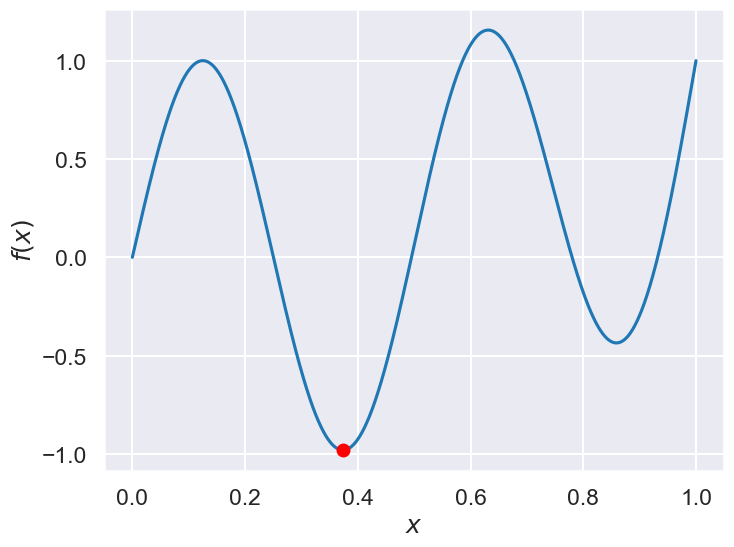

In [4]:
# Plot the function and the minimum that scipy found
X_domain = np.linspace(xmin,xmax,1000)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(X_domain, Ftrue(X_domain))
ax.plot(result.x[0], result.fun, 'ro')
ax.set(xlabel=r'$x$', ylabel=r'$f(x)$');

In [5]:
# parameter bound(s) 
bounds = [{'name': 'x_1', 'type': 'continuous', 'domain': (xmin,xmax)}]

In [6]:
# We'll consider two choices for the acquisition function, expectived 
#  improvement (EI) and lower confidence bound (LCB)
my_acquisition_type = 'EI'
#my_acquisition_type = 'LCB'

# Creates GPyOpt object with the model and aquisition function
myBopt = GPyOpt.methods.BayesianOptimization(\
            f=Ftrue,                  # function to optimize   
            initial_design_numdata=1, # Start with two initial data
            domain=bounds,            # box-constraints of the problem
            acquisition_type=my_acquisition_type, # Selects acquisition type
            exact_feval = True) 

In [7]:
# Run the optimization
np.random.seed(123)   # (123)
max_iter = 1      # evaluation budget (max_iter=1 means one step at a time)
max_time = 60     # time budget 
eps      = 1.e-6  # minimum allowed distance between the last two observations

Now we can use the GPyOpt `run_optimization` one step at a time (meaning we add one point per iteration), plotting the GP mean (solid black line) and 95% (??) variance (gray line) and the acquisition function in red using `plot_acquisition`.  The maximum of the acquisition function, which will be the choice for $x$ in the next iteration, is marked by a vertical red line. 

**What can you tell about the GP used as a surrogate for $f(x)$?**

Note how the GP is refined (updated) with additional points.

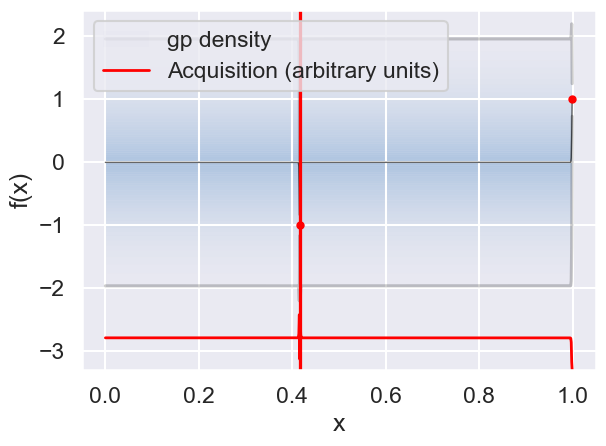

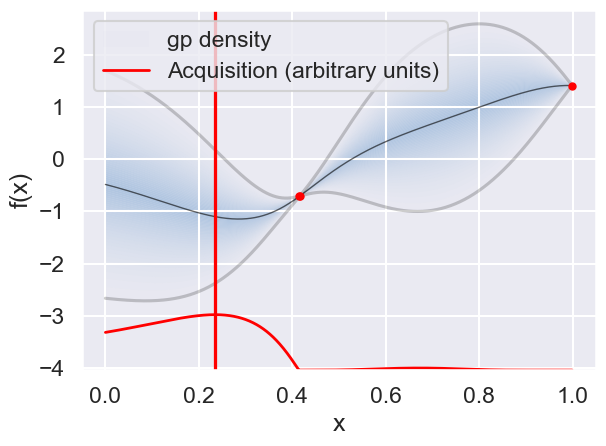

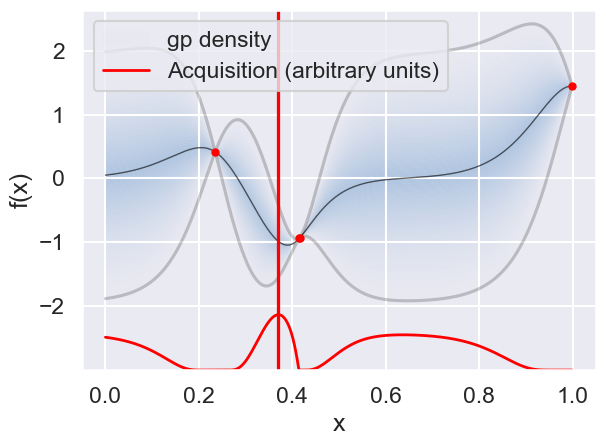

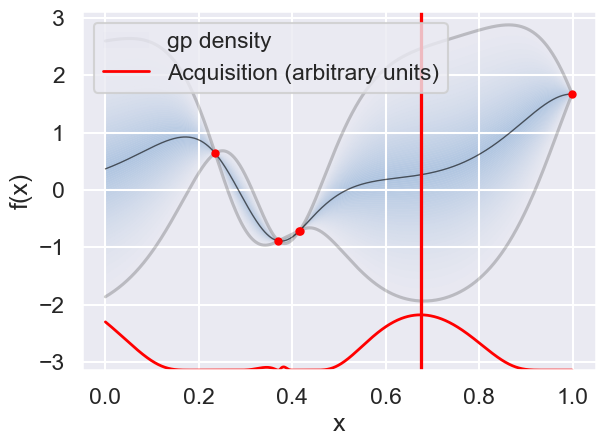

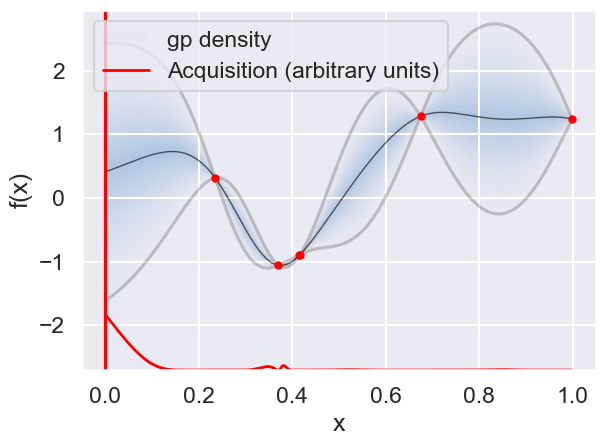

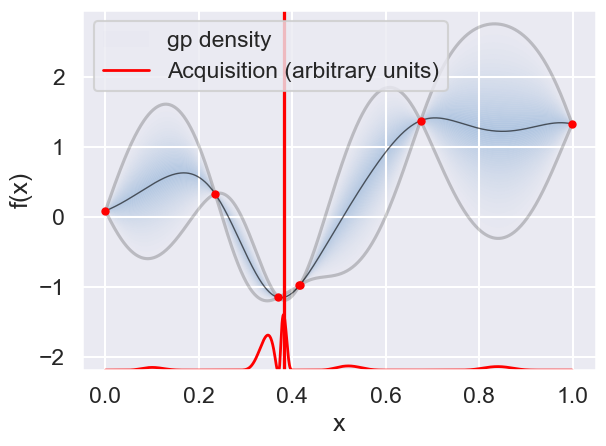

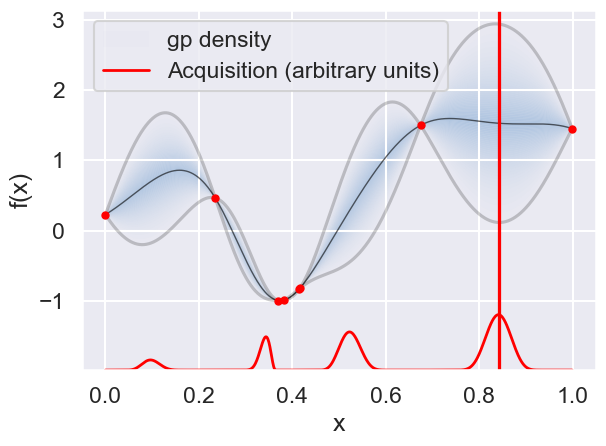

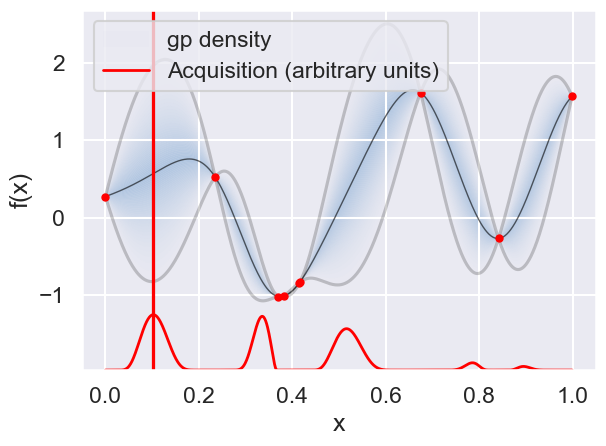

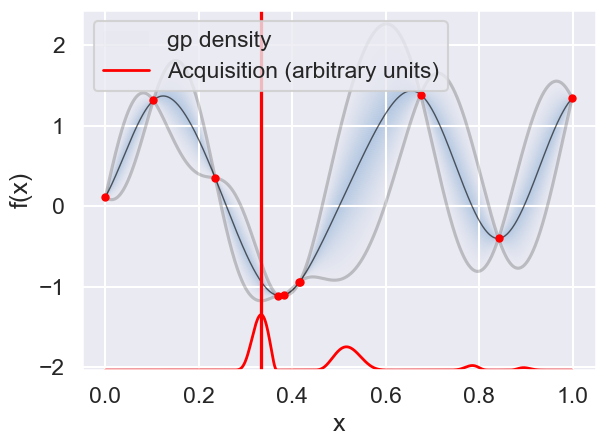

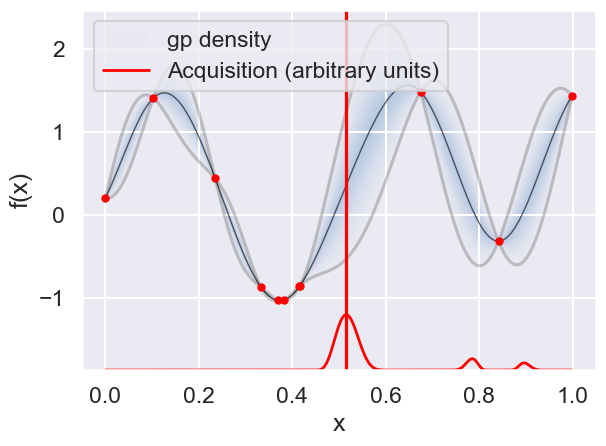

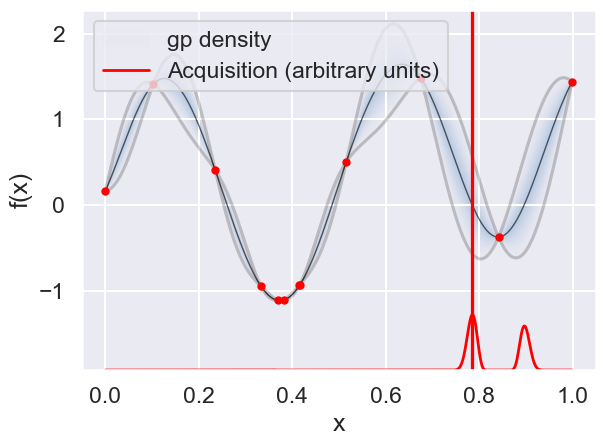

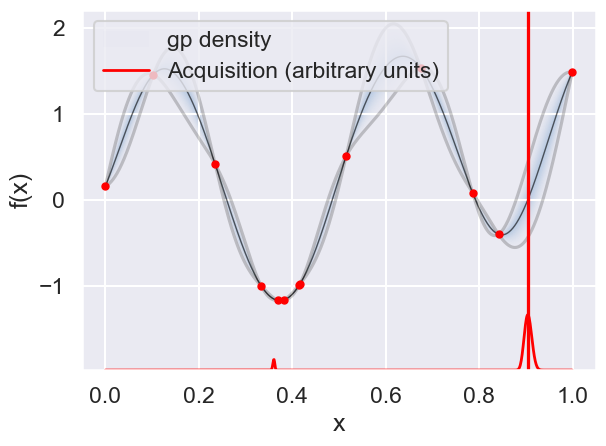

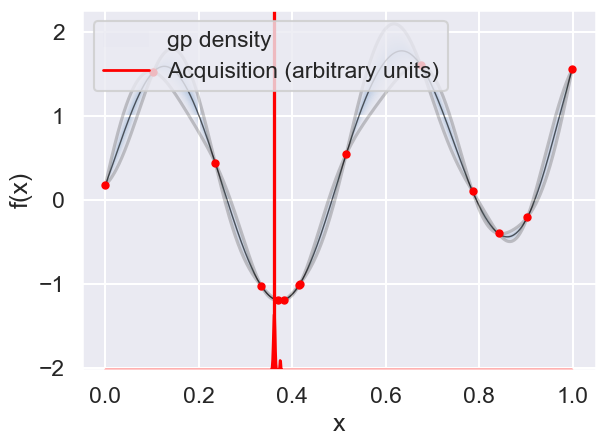

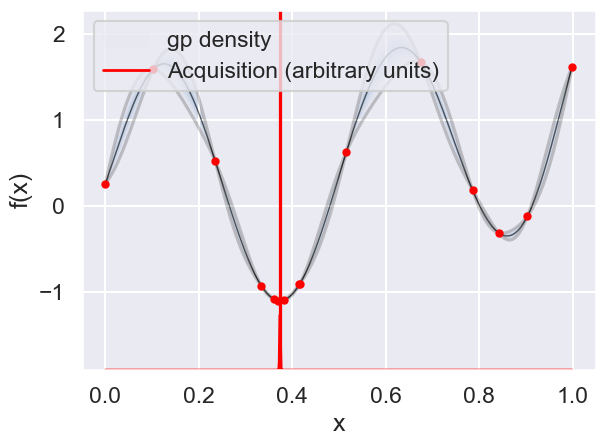

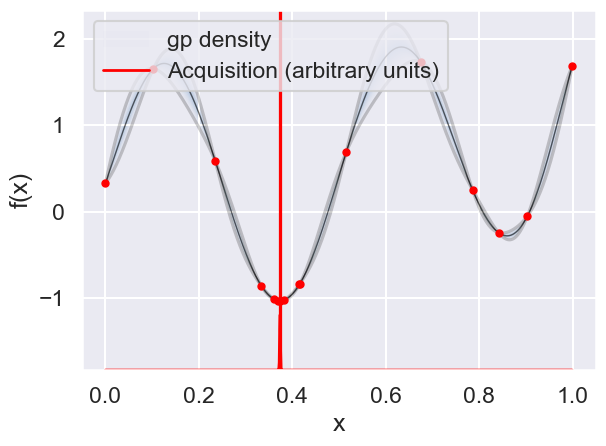

In [8]:
# run for num_iter iterations
num_iter = 15
for i in range(num_iter):
    myBopt.run_optimization(max_iter, max_time, eps)                     
    myBopt.plot_acquisition()

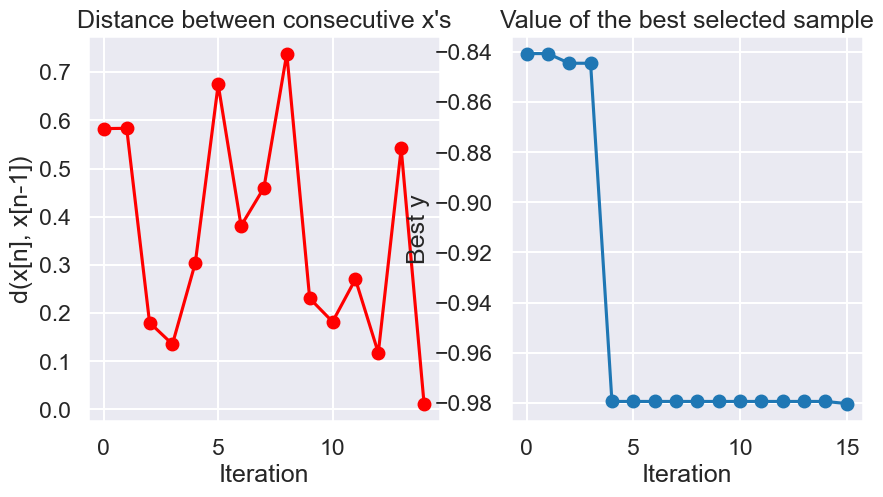

Optimal x value = [0.37378141]
Minimized function value = -0.98036


In [9]:
# From the docstring:
# Makes two plots to evaluate the convergence of the model:
#   plot 1: Iterations vs. distance between consecutive selected x's
#   plot 2: Iterations vs. the mean of the current model in the selected sample.

myBopt.plot_convergence()
print(f'Optimal x value = {myBopt.x_opt}')
print(f'Minimized function value = {myBopt.fx_opt:.5f}')

## Bivariate example (two parameters)

Next, we try a 2-dimensional example. In this case we minimize the Six-hump camel function

$$
f(\theta_1,\theta_2)=\left( 4−2.1 \theta_1^2 + \frac{\theta_1^4}{3}\right)\theta_1^2+\theta_1 \theta_2+\left(−4+4\theta_2^2\right)\theta_2^2,
$$

in $[−3,3]$, $[−2,2]$. This functions has two global minimum, at (0.0898, −0.7126) and (−0.0898, 0.7126), with function value -1.0316. The function is already pre-defined in `GPyOpt`. In this case we generate observations of the function perturbed with white noise of first of sd=0.01 and then sd=0.1.

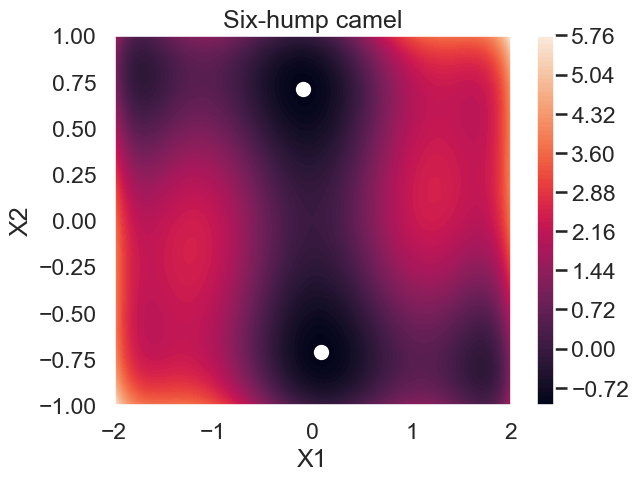

In [10]:
# create the object function
f_true = GPyOpt.objective_examples.experiments2d.sixhumpcamel()
f_sim = GPyOpt.objective_examples.experiments2d.sixhumpcamel(sd = 0.1)
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]},
         {'name': 'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]}]
f_true.plot()

In [11]:
# Note that exact_feval is set to False here because of the white noise.
myBopt2D = GPyOpt.methods.BayesianOptimization(f_sim.f,
                                               domain=bounds,
                                               model_type = 'GP',
                                               acquisition_type='EI',  
                                               normalize_Y = True,
                                               exact_feval = False)    

In [12]:
# runs the optimization for the three methods
max_iter = 40  # maximum time 40 iterations
max_time = 60  # maximum time 60 seconds

myBopt2D.run_optimization(max_iter,max_time,verbosity=False)            

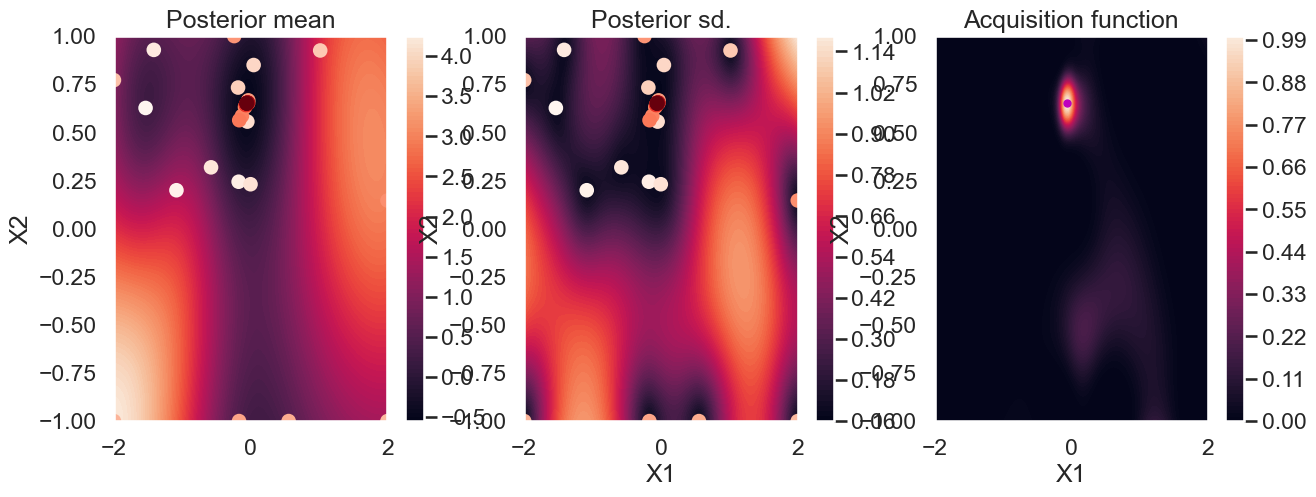

<Figure size 640x480 with 0 Axes>

In [13]:
myBopt2D.plot_acquisition() 
plt.tight_layout();  # This doesn't seem to help.  How to fix spacing?


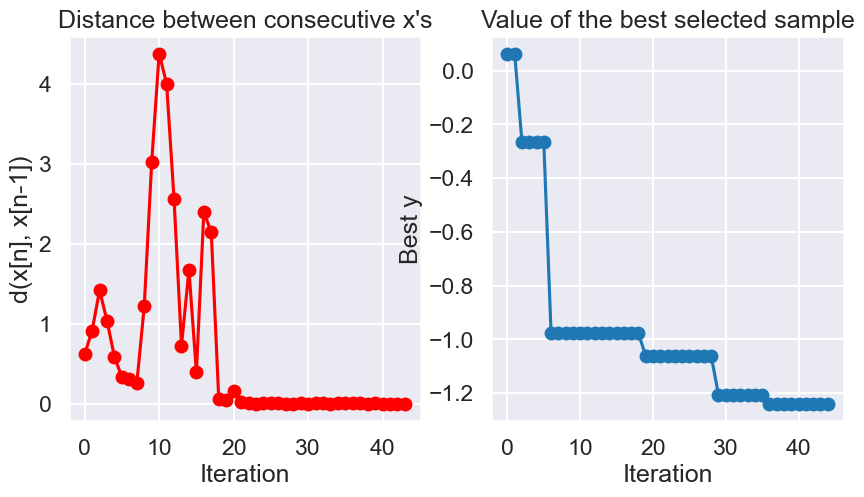

Optimal x values = [-0.0527113  0.6529242]
Minimized function value = -1.23848


In [14]:
myBopt2D.plot_convergence()
print(f'Optimal x values = {myBopt2D.x_opt}')
print(f'Minimized function value = {myBopt2D.fx_opt:.5f}')

### Space-filling sampling

![sampling](https://raw.githubusercontent.com/buqeye/LearningFromData/main/LectureNotes/_images/space_filling_sampling.png)

* Sobol sequence sampling in Python, e.g. with [sobol_seq](https://github.com/naught101/sobol_seq)
* Latin Hypercube Sampling in Python, e.g. with [pyDOE](https://pythonhosted.org/pyDOE/index.html)
* Mersenne-Twister is the core random number generator in Python / numpym

## Some concluding remarks
from the paper [arXiv:1902.00941](https://arxiv.org/abs/1902.00941): 
* **Prior knowledge/belief is everything!** Important to tailor the acquisition function and the GP kernel to the spatial structure of the objective function. Thus, the usefulness of BayesOpt hinges on the arbitrariness and uncertainty of a priori information. Complicated by the fact that we resort to BayesOpt when little is known about the objective function in the first place, since it is computationally expensive to evaluate. 
* In general, BayesOpt will never find a narrow minimum **nor be useful for extracting the exact location of any optimum**. So one might want to use it as the first stage in a hierarchical optimization scheme to identify the interesting regions of parameter space.  One may also want to switch from a more explorative acquisition function in early iterations to more exploitive in later iterations.
* We find that the **acquisition function is more important** than the form of the GP-kernel. 
* BayesOpt would probably benefit from a prior that captures the **large-scale structure of the objective function**.
* **High-dimensional parameter domains** are always challenging (subspace learning, dim reduction).